<a href="https://colab.research.google.com/github/bharath-r17/project/blob/main/customer_segmentation_and_visualizations_in_plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-family:verdana;"> <center>  Data Visualization with Plotly </center> </h1>


***

***

In [1]:
!pip install texthero

In [2]:
!pip install jupyter_dash

In [3]:
# Basic libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from scipy import stats
import json

# NLP libraries
import texthero as hero
from nltk.tokenize import ToktokTokenizer

# Data visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import model_selection

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from xgboost import XGBClassifier
from xgboost import plot_importance



In [4]:
! pip install kaggle


In [5]:
 ! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp kaggle.json ~/.kaggle/



In [7]:
! chmod 600 ~/.kaggle/kaggle.json


In [8]:
! kaggle datasets download mashlyn/online-retail-ii-uci


online-retail-ii-uci.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip /content/online-retail-ii-uci.zip


Archive:  /content/online-retail-ii-uci.zip
replace online_retail_II.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: online_retail_II.csv    


In [10]:

df = pd.read_csv('/content/online_retail_II.csv',encoding= 'unicode_escape')

***

<h1 id="clean" style="font-family:verdana;"> 
    <center>1. Cleaning Data 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#clean">¶</a>
    </center>
</h1>

> <h2 id="missing" style="font-family:verdana;"> 
>          1.1 Missing data 
>         <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#missing">¶</a>
> 
</h2>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> After an exploratory analysis of the dataset, it appears that <span style="color:crimson;"> 22% </span>of the customer ids are missing which is very problematic since I want to do a <span style="color:crimson;"> Customer </span> Segmentation later. I've tried looking at the invoice number or date without success. It's a shame that we have to lose 22% of the data but we don't have a choice.

In [11]:
df = df.dropna(subset=["Customer ID"])

<h2 id="duplicates" style="font-family:verdana;"> 
         1.2 Duplicate values
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#duplicates">¶</a>

</h2>

In [12]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
df.drop_duplicates(inplace = True)

Duplicate entries: 26479


<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b>Since duplicates values aren't following one another in the dataset, I could think that the customer added the same product in his basket several times without updating the quantity. The choice is here also hard to make. But, by trying this experiment on a few websites, it seems that the quantity is always updated when you add the same product. So I'll consider them as duplicates even though this data is from 2010.</b><br><br>
</div>

<h2 id="dupplicates" style="font-family:verdana;"> 
         1.3 Stock Code
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#dupplicates">¶</a>

</h2>

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b> In this dataset, there are several specific transactions which aren't products. For example, we can have a line with 'Discount' as a description. This probably means that the customer had a discount during his purchase. Before deleting lines that aren't product, I'll create 2 features : discount and postage in which I'll store different discounts and postage customers had.</b><br><br>
</div>

In [13]:
df['Discount'] = 0
for index, col in  df[df['StockCode']=='D'].iterrows():
    invoice = col['Invoice']
    price = col['Price']
    
    df.loc[(df.Invoice == invoice), 'Discount'] = price
    

In [14]:
df['Postage'] = 0
for index, col in  df[df['StockCode']=='POST'].iterrows():
    invoice = col['Invoice']
    price = col['Price']
    
    df.loc[(df.Invoice == invoice), 'Postage'] = price
    

In [15]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes 

array(['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002', 'DOT', 'CRUK'], dtype=object)

In [16]:
for code in list_special_codes : 
    df = df[df['StockCode']!= code]

<h2 id="canceled" style="font-family:verdana;"> 
         1.4 Canceled Orders
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#canceled">¶</a>

</h2>

In [17]:
df_cleaned = df.copy(deep = True)


In [18]:

df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['Customer ID'] == col['Customer ID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

In [19]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 15942
doubtfull_entry: 1532


In [20]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 112


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Discount,Postage,QuantityCanceled
9324,C490133,21314,SMALL GLASS HEART TRINKET POT,-504,2009-12-03 18:36:00,1.85,17949.0,United Kingdom,0.0,0.0,0
28066,C491728,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-4,2009-12-14 09:18:00,4.95,12471.0,Germany,0.0,0.0,0
46326,C493689,79000,MOROCCAN TEA GLASS,-18,2010-01-05 12:45:00,0.85,14606.0,United Kingdom,0.0,0.0,0
47742,C493836,84050,PINK HEART SHAPE EGG FRYING PAN,-24,2010-01-07 13:49:00,1.65,12839.0,United Kingdom,0.0,0.0,0
69168,C495516,72739C,DARK CHOCOLATE SCENTCANDLE,-13,2010-01-25 14:26:00,1.25,13564.0,United Kingdom,0.0,0.0,0


In [21]:
df_cleaned.drop(remaining_entries.index, axis = 0, inplace = True)

***

<h1 id="products_tag" style="font-family:verdana;"> 
    <center>2. Product Tagging 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#products_tag">¶</a>
    </center>
</h1>

<h2 id="desc_clean" style="font-family:verdana;"> 
         2.1 Cleaning the description
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#desc_clean">¶</a>

</h2>

In [22]:
product_df = df_cleaned.drop(columns=['StockCode', 'Invoice', 'Customer ID', 'Price', 'Quantity', 'InvoiceDate', 'Country'])
product_df['Description'] = df['Description'].pipe(hero.clean)

In [23]:
tw = hero.visualization.top_words(product_df['Description']).head(40)

fig = px.bar(tw)
fig.show()

<h2 id="prod_color" style="font-family:verdana;"> 
         2.2 Product's color 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_color">¶</a>

</h2>

In [24]:
token = ToktokTokenizer()

In [25]:
def TagExtractor(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if  w in tags]
    
    return ' '.join(map(str, filtered))

In [26]:

def TagRemove(text, tags):
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in tags]
    
    return ' '.join(map(str, filtered))

In [27]:
colors = ['black', 'blue', 'brown', 'gold', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'silver', 'white', 'yellow', 'ivory']

In [28]:
product_df['ProductColor'] = product_df['Description'].apply(lambda x: TagExtractor(x, colors)) 

In [29]:
 product_df['Description'] = product_df['Description'].apply(lambda x: TagRemove(x, colors)) 

In [30]:
tw = hero.visualization.top_words(product_df['ProductColor']).head(20)

fig = px.bar(tw)
fig.show()

<h2 id="prod_des" style="font-family:verdana;"> 
         2.3 Product's design
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_des">¶</a>

</h2>

In [31]:
Design = ['gingham', 'butterfly', 'chocolate', 'zinc', 'hearts', 'star', 'skull', 'dolly', 'wood', 'retro', 'strawberry',
         'mini', 'polkadot', 'spot', 'cream', 'rose', 'spaceboy', 'ceramic', 'glasse', 'vintage', 'retrospot', 'heart',
         'spots', 'skulls', 'scandinavian', 'london', 'french', 'wooden', 'woodland', 'bakelike', 'feltrcraft', 'porcelain',
         'spaceboy', 'glass', 'traditional', 'bird', 'birds', 'flower', 'antique', 'tube']

In [32]:
product_df['Design'] = product_df['Description'].apply(lambda x: TagExtractor(x, Design)) 

In [33]:
stop_words = ['set', 'pack', 'small', 'large']

In [34]:
 product_df['Description'] = product_df['Description'].apply(lambda x: TagRemove(x, (Design+stop_words))) 

In [35]:
tw = hero.visualization.top_words(product_df['Design']).head(20)

fig = px.bar(tw)
fig.show()

<h2 id="prod_cat" style="font-family:verdana;"> 
         2.4 Product's category
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat">¶</a>

</h2>

<h3 id="prod_cat_man" style="font-family:verdana;"> 
         2.4.1 Semi manually tagging products
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat_man">¶</a>

</h3>

In [36]:
Categories = ['bag', 'box', 'cake', 'christmas', 'hanging', 'light', 'holder', 'sign', 'jumbo', 'lunch', 'paper', 'tea', 'card',
              'cases', 'decoration', 'water', 'bottle', 'mug', 'party', 'garden', 'wrap', 'bowl', 'birthday', 
              'photo', 'frame', 'candle', 'key', 'ring', 'travel', 'egg', 'cup', 
              'lights', 'cutlery', 'candles', 'door', 'gift', 'clock', 'trinket', 
              'drawer', 'stand', 'pencils', 'ribbons', 'napkins', 'notebook', 'photo', 'alarm', 'dog',
             'kitchen', 'storage', 'childrens', 'cup', 'cat', 'wall', 'art', 'cushion', 'cover', 'popcorn', 'soap', 'baking', 'door']


In [37]:
product_df['Categories'] = product_df['Description'].apply(lambda x: TagExtractor(x, Categories)) 

In [38]:
pd.DataFrame(product_df['Categories'].value_counts()).to_excel('product_categories.xlsx')

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b>  From here, I took it on excel. I renamed and grouped categories into labels in order to have something more reliable for the classifiers later on. </b><br><br>
    
</div>

In [39]:
product_tags = pd.read_excel('/content/product_categories.xlsx')

In [40]:
product_tags.head()

,Unnamed: 0,Categories
0,NaN,281397
1,bag,23199
2,sign,21932
3,box,19839
4,jumbo bag,19189


In [41]:
product_df = product_df.reset_index().merge(product_tags, on='Categories', how='left').set_index('index')

ValueError: ignored

In [42]:
product_df.loc[(product_df.Description =='wicker'), 'Labels'] = 'Wicker'

product_df.loc[(product_df.Description =='assorted colour ornament'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='tissues'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='chalkboard'), 'Labels'] = 'Stationary'

product_df.loc[(product_df.Description =='milk jug'), 'Labels'] = 'Tableware'

product_df.loc[(product_df.Description =='measuring spoons'), 'Labels'] = 'Baking'

product_df.loc[(product_df.Description =='snap cards'), 'Labels'] = 'Cards'

In [43]:
product_df.loc[(product_df.Description =='regency cakestand tier'), 'Labels'] = 'Cake Decoration'

product_df.loc[(product_df.Description =='heart wicker small'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='heart wicker large'), 'Labels'] = 'Hanging Decoration'

product_df.loc[(product_df.Description =='edwardian parasol'), 'Labels'] = 'Essentials'

product_df.loc[(product_df.Description =='regency teacup saucer'), 'Labels'] = 'Tea'

product_df.loc[(product_df.Description =='natural slate heart chalkboard'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='french metal door sign'), 'Labels'] = 'Door Sign'

product_df.loc[(product_df.Description =='love building block word'), 'Labels'] = 'Home Decoration'

product_df.loc[(product_df.Description =='vintage snap cards'), 'Labels'] = 'Cards'

product_df.loc[(product_df.Description =='scottie dog hot water bottle'), 'Labels'] = 'Water Bottle'

product_df.loc[(product_df.Labels =='Holders'), 'Labels'] = 'Holding Decoration'

In [44]:
for label in ['Decorative Storage', 'Hanging Decoration', 'Lights', 'Candles', 'Door Signs', 'Wall Signs', 'Wicker', 'Clocks',
             'Storage', 'Frame', 'Photo Frame', 'Wall Art', 'Holding Decoration', 'Popcorn Holder']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Home Decoration'

In [45]:
for label in ['Lunch Bags', 'Jumbo Bags', 'Jumbo Shopper']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Bags'

In [46]:
for label in ['Cards', 'Paper', 'Cushions', 'Wraps', 'Gift Wraps']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Gifts'

In [47]:
for label in ['Water Bottle', 'Essentials', 'Travel', 'Pets', 'Jewelry']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Other'

In [48]:
for label in ['Cake Decoration', 'Birthday']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Party'

In [49]:
for label in ['Tea', 'Baking', 'Kitchen', 'Soap']:
    product_df.loc[(product_df.Labels ==label), 'Labels'] = 'Tableware'

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b>   I decided that I had too many categories and wanted to squeeze them into 10 new labels. </b><br><br>
</div>

In [50]:
product_df['Labels'].value_counts().sum() /product_df['Labels'].shape[0]*100

3.2774642464883854

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b> One last finishing touch and we're done. With this semi-manual work almost 60% of the data is tagged which should give us enough data for the next step </b><br><br>
</div>

<h3 id="prod_cat_auto" style="font-family:verdana;"> 
         2.4.2 Training classification algorithms 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_cat_auto">¶</a>

</h3>

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b> I've now landed on the fun and last part of this notebook. I'll use my labeled data in order to train classifiers and validate results on it. Once this is done, I'll simply choose the best classifiers and predict labels for the test data. This was the plan but it didn't go that smoothly. </b><br><br>
</div>

In [51]:
X = product_df.dropna(subset=['Labels']).drop_duplicates(subset=['Description'])['Description']
X_test = product_df[product_df['Labels'].isnull()]['Description']

In [52]:
X.shape, X_test.shape

((11,), (751183,))

In [53]:
le = preprocessing.LabelEncoder()

In [54]:
y = le.fit_transform(product_df.dropna(subset=['Labels']).drop_duplicates(subset=['Description'])['Labels'])

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, random_state = 46) # Do 60/40 split

In [56]:
X_vectorizer = TfidfVectorizer(analyzer = 'word',
                            )

In [57]:
X_train = X_vectorizer.fit_transform(X_train)
X_val =  X_vectorizer.transform(X_val)
X_test_tfidf = X_vectorizer.transform(X_test)

In [58]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy score: {}".format(accuracy_score(y_val, y_pred)))
    print("---")    

In [59]:
dummy = DummyClassifier(strategy='prior')
sgd = SGDClassifier()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()


for classifier in [dummy, sgd, mn, svc, perceptron, pac, mlpc, rfc, xgb]:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Accuracy score: 0.2
---
Clf:  SGDClassifier
Accuracy score: 0.2
---
Clf:  MultinomialNB
Accuracy score: 0.2
---
Clf:  LinearSVC
Accuracy score: 0.2
---
Clf:  Perceptron
Accuracy score: 0.0
---
Clf:  PassiveAggressiveClassifier
Accuracy score: 0.2
---
Clf:  MLPClassifier
Accuracy score: 0.2
---
Clf:  RandomForestClassifier
Accuracy score: 0.2
---
Clf:  XGBClassifier
Accuracy score: 0.2
---


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b> We could have better results by tuning some parameterers but for now I'm going to keep it that way and come back to it later. </b><br><br>
</div>

In [60]:
y_pred_test = rfc.predict(X_test_tfidf) 

In [61]:
prods_non_labeled = pd.DataFrame()

In [62]:
prods_non_labeled['Description']= X_test

In [63]:
prods_non_labeled['Labels'] = le.inverse_transform(y_pred_test)

In [64]:
prods_non_labeled

,Description,Labels
0,15cm christmas ball lights,Other
1,cherry lights,Other
2,cherry lights,Other
3,record frame single size,Other
4,trinket box,Other
...,...,...
1067365,napkins,Other
1067366,children apron girl,Other
1067367,childrens cutlery girl,Other
1067368,childrens cutlery circus parade,Other


In [65]:
product_df.loc[(product_df.Labels.isnull()), 'Labels'] = prods_non_labeled['Labels']

In [66]:
product_df

,Description,Discount,Postage,QuantityCanceled,ProductColor,Design,Categories,Labels
0,15cm christmas ball lights,0.0,0.0,0,,glass,christmas lights,Other
1,cherry lights,0.0,0.0,0,pink,,lights,Other
2,cherry lights,0.0,0.0,0,white,,lights,Other
3,record frame single size,0.0,0.0,0,,,frame,Other
4,trinket box,0.0,0.0,0,,strawberry ceramic,trinket box,Other
...,...,...,...,...,...,...,...,...
1067365,napkins,0.0,18.0,0,,spaceboy,napkins,Other
1067366,children apron girl,0.0,18.0,0,,dolly,,Other
1067367,childrens cutlery girl,0.0,18.0,0,,dolly,childrens cutlery,Other
1067368,childrens cutlery circus parade,0.0,18.0,0,,,childrens cutlery,Other


In [67]:
product_df.shape, df.shape

((776637, 8), (794223, 10))

In [68]:
df_cleaned['ProductColor'] = product_df['ProductColor']
df_cleaned['Design'] = product_df['Design']
df_cleaned['Labels'] = product_df['Labels']

In [69]:
df_cleaned['Labels'].value_counts(dropna=False)

Other              748938
Home Decoration     12389
Tableware            7866
Party                3810
Gifts                3634
Name: Labels, dtype: int64

***

<h1 id="Feature_engin" style="font-family:verdana;"> 
    <center>3. Feature Engineering
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#Feature_engin">¶</a>
    </center>
</h1>

<h2 id="total_price" style="font-family:verdana;"> 
         3.1 Total Price
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/total_price">¶</a>

</h2>

In [70]:
# Total price feature

df_cleaned['TotalPrice'] = df_cleaned['Price'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [71]:
df_cleaned['TotalPrice'].describe()

count    776637.000000
mean         21.078978
std          65.060980
min        -413.100000
25%           4.950000
50%          11.800000
75%          19.500000
max        8925.000000
Name: TotalPrice, dtype: float64

In [72]:
df_cleaned[df_cleaned['TotalPrice']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Discount,Postage,QuantityCanceled,ProductColor,Design,Labels,TotalPrice
221,489460,79323S,SILVER CHERRY LIGHTS,4,2009-12-01 10:46:00,6.75,16167.0,United Kingdom,0.0,0.0,5,silver,,Other,-6.75
12138,490372,79323B,BLACK CHERRY LIGHTS,4,2009-12-05 12:13:00,6.75,17115.0,United Kingdom,0.0,0.0,12,black,,Other,-54.00
12582,490400,79323B,BLACK CHERRY LIGHTS,2,2009-12-06 10:41:00,6.75,16104.0,United Kingdom,0.0,0.0,4,black,,Other,-13.50
12583,490400,79323G,GOLD CHERRY LIGHTS,3,2009-12-06 10:41:00,6.75,16104.0,United Kingdom,0.0,0.0,4,gold,,Other,-6.75
12584,490400,79323S,SILVER CHERRY LIGHTS,3,2009-12-06 10:41:00,6.75,16104.0,United Kingdom,0.0,0.0,4,silver,,Other,-6.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840402,564670,21197,MULTICOLOUR CONFETTI IN TUBE,12,2011-08-26 15:44:00,1.65,12683.0,France,0.0,18.0,21,,tube,Other,-14.85
859081,566203,23356,LOVE HOT WATER BOTTLE,2,2011-09-09 14:47:00,5.95,16362.0,United Kingdom,0.0,0.0,4,,,Other,-11.90
938355,572301,22371,AIRLINE BAG VINTAGE TOKYO 78,1,2011-10-23 14:41:00,4.25,16794.0,United Kingdom,0.0,0.0,2,,vintage,Other,-4.25
965547,574506,23085,ANTIQUE SILVER BAUBLE LAMP,3,2011-11-04 13:24:00,10.40,12577.0,France,0.0,0.0,6,silver,antique,Other,-31.20


<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
     <b> We can't have more quantities canceled than bought initially. I'm deleting these lines. </b><br><br>
</div>

In [73]:
df_cleaned.drop(df_cleaned[df_cleaned['TotalPrice']<0].index, axis = 0, inplace = True)

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> Let's clean the outliers real quick. I'll delete transactions which are 10 times greater than usual. </b><br><br>
</div>

In [74]:
z = np.abs(stats.zscore(df_cleaned['TotalPrice']))
threshold = 10

df_cleaned_outliers = df_cleaned.copy(deep=True)
df_cleaned_outliers['Outliers'] = z

df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Discount,Postage,QuantityCanceled,ProductColor,Design,Labels,TotalPrice,Outliers
575,489523,84879,ASSORTED COLOUR BIRD ORNAMENT,800,2009-12-01 11:46:00,1.45,12931.0,United Kingdom,0.0,0.0,0,,bird,Home Decoration,1160.0,17.505476
3290,489675,15056BL,EDWARDIAN PARASOL BLACK,240,2009-12-02 09:47:00,4.60,13777.0,United Kingdom,0.0,0.0,5,black,,Other,1081.0,16.291223
3511,489702,22086,PAPER CHAIN KIT 50'S CHRISTMAS,280,2009-12-02 10:52:00,2.55,17511.0,United Kingdom,0.0,0.0,2,,,Other,708.9,10.571939
3570,489726,21428,SET3 BOOK BOX GREEN GINGHAM FLOWER,200,2009-12-02 11:07:00,3.75,17949.0,United Kingdom,0.0,0.0,0,green,gingham flower,Other,750.0,11.203658
3572,489727,22086,PAPER CHAIN KIT 50'S CHRISTMAS,450,2009-12-02 11:09:00,2.00,17949.0,United Kingdom,0.0,0.0,0,,,Other,900.0,13.509201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065523,581457,82484,WOOD BLACK BOARD ANT WHITE FINISH,204,2011-12-08 18:43:00,4.80,18102.0,United Kingdom,0.0,0.0,0,black white,wood,Other,979.2,14.726528
1065524,581457,23553,LANDMARK FRAME CAMDEN TOWN,120,2011-12-08 18:43:00,10.95,18102.0,United Kingdom,0.0,0.0,0,,,Other,1314.0,19.872500
1065525,581457,23542,WALL ART 70'S ALPHABET,120,2011-12-08 18:43:00,6.67,18102.0,United Kingdom,0.0,0.0,0,,,Other,800.4,11.978321
1065531,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom,0.0,0.0,0,,,Other,1080.0,16.275853


In [75]:
df_cleaned.drop(df_cleaned_outliers[df_cleaned_outliers['Outliers']>threshold].index, axis = 0, inplace = True)

<h2 id="time_features" style="font-family:verdana;"> 
         3.2 Time Features
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/time_features">¶</a>

</h2>

In [76]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [77]:
df_cleaned['Year'] = df_cleaned["InvoiceDate"].apply(lambda x: x.year)
df_cleaned['Month'] = df_cleaned["InvoiceDate"].apply(lambda x: x.month)
df_cleaned['MonthYear'] = df_cleaned["InvoiceDate"].apply(lambda x: x.strftime("%B %Y"))
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].apply(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].apply(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].apply(lambda x: x.hour)

<h2 id="rfm" style="font-family:verdana;"> 
         3.3 RFM Principle
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#rfm**">¶</a>

</h2>

In [78]:
df_cleaned['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [79]:
df_cleaned['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [80]:
NOW = dt.datetime(2011,12,10)

In [81]:
df_cleaned.shape[0] / df_cleaned['Invoice'].value_counts().count() 

21.314717603408

In [82]:
custom_aggregation = {}
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["Customer ID"] = lambda x:x.iloc[0]
custom_aggregation["TotalPrice"] = "sum"

In [83]:
rfmTable = df_cleaned.groupby("Invoice").agg(custom_aggregation)

In [84]:
rfmTable["Recency"] = NOW - rfmTable["InvoiceDate"]
rfmTable["Recency"] = pd.to_timedelta(rfmTable["Recency"]).astype("timedelta64[D]")

In [85]:
rfmTable.head(5)

,InvoiceDate,Customer ID,TotalPrice,Recency
Invoice,,,,
489434,2009-12-01 07:45:00,13085.0,505.30,738.0
489435,2009-12-01 07:46:00,13085.0,145.80,738.0
489436,2009-12-01 09:06:00,13078.0,630.33,738.0
489437,2009-12-01 09:08:00,15362.0,310.75,738.0
489438,2009-12-01 09:24:00,18102.0,2286.24,738.0


In [86]:
custom_aggregation = {}

custom_aggregation["Recency"] = ["min", "max"]
custom_aggregation["InvoiceDate"] = lambda x: len(x)
custom_aggregation["TotalPrice"] = "sum"

In [87]:
rfmTable_final = rfmTable.groupby("Customer ID").agg(custom_aggregation)

In [88]:
rfmTable_final.columns = ["min_recency", "max_recency", "frequency", "monetary_value"]

In [89]:
rfmTable_final.head(5)

,min_recency,max_recency,frequency,monetary_value
Customer ID,,,,
12346.0,325.0,647.0,3,169.36
12347.0,2.0,404.0,8,4921.53
12348.0,75.0,438.0,5,1658.40
12349.0,18.0,589.0,3,3678.69
12350.0,310.0,310.0,1,294.40


In [90]:
first_customer = df_cleaned[df_cleaned['Customer ID']==12346.0]
first_customer.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Discount,Postage,...,ProductColor,Design,Labels,TotalPrice,Year,Month,MonthYear,Weekday,Day,Hour
107800,499763,20682,RED SPOTTY CHILDS UMBRELLA,1,2010-03-02 13:08:00,3.25,12346.0,United Kingdom,0.0,0.0,...,red,,Other,3.25,2010,3,March 2010,1,2,13
107801,499763,20679,EDWARDIAN PARASOL RED,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,0.0,0.0,...,red,,Other,5.95,2010,3,March 2010,1,2,13
107802,499763,15056N,EDWARDIAN PARASOL NATURAL,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,0.0,0.0,...,,,Other,5.95,2010,3,March 2010,1,2,13
107803,499763,15056BL,EDWARDIAN PARASOL BLACK,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,0.0,0.0,...,black,,Other,5.95,2010,3,March 2010,1,2,13
107804,499763,15056P,EDWARDIAN PARASOL PINK,1,2010-03-02 13:08:00,5.95,12346.0,United Kingdom,0.0,0.0,...,pink,,Other,5.95,2010,3,March 2010,1,2,13


In [91]:
quantiles = rfmTable_final.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [92]:
segmented_rfm = rfmTable_final

In [93]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [94]:
segmented_rfm['r_quartile'] = segmented_rfm['min_recency'].apply(RScore, args=('min_recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
Customer ID,,,,,,,
12346.0,325.0,647.0,3,169.36,3,3,4
12347.0,2.0,404.0,8,4921.53,1,1,1
12348.0,75.0,438.0,5,1658.40,2,2,2
12349.0,18.0,589.0,3,3678.69,1,3,1
12350.0,310.0,310.0,1,294.40,3,4,4


In [95]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
Customer ID,,,,,,,,
12346.0,325.0,647.0,3,169.36,3,3,4,334
12347.0,2.0,404.0,8,4921.53,1,1,1,111
12348.0,75.0,438.0,5,1658.40,2,2,2,222
12349.0,18.0,589.0,3,3678.69,1,3,1,131
12350.0,310.0,310.0,1,294.40,3,4,4,344


In [96]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
Customer ID,,,,,,,,
14646.0,1.0,737.0,140,483455.23,1,1,1,111
14911.0,1.0,738.0,373,258961.81,1,1,1,111
14156.0,9.0,738.0,142,240029.36,1,1,1,111
18102.0,0.0,738.0,114,188732.88,1,1,1,111
13694.0,3.0,735.0,143,188447.56,1,1,1,111
...,...,...,...,...,...,...,...,...
14467.0,17.0,737.0,12,2203.24,1,1,1,111
16076.0,3.0,208.0,10,2173.53,1,1,1,111
13410.0,24.0,731.0,9,2172.51,1,1,1,111


In [97]:
segmented_rfm.head(5)

,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
Customer ID,,,,,,,,
12346.0,325.0,647.0,3,169.36,3,3,4,334
12347.0,2.0,404.0,8,4921.53,1,1,1,111
12348.0,75.0,438.0,5,1658.40,2,2,2,222
12349.0,18.0,589.0,3,3678.69,1,3,1,131
12350.0,310.0,310.0,1,294.40,3,4,4,344


In [98]:
segmented_rfm = segmented_rfm.reset_index()

In [99]:
segmented_rfm.head(5)

,Customer ID,min_recency,max_recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
0,12346.0,325.0,647.0,3,169.36,3,3,4,334
1,12347.0,2.0,404.0,8,4921.53,1,1,1,111
2,12348.0,75.0,438.0,5,1658.40,2,2,2,222
3,12349.0,18.0,589.0,3,3678.69,1,3,1,131
4,12350.0,310.0,310.0,1,294.40,3,4,4,344


In [100]:
df_cleaned.shape

(775536, 21)

In [101]:
df_cleaned = pd.merge(df_cleaned,segmented_rfm, on='Customer ID')

In [102]:
df_cleaned = df_cleaned.drop(columns=['r_quartile', 'f_quartile', 'm_quartile'])

<h2 id="prod_exp" style="font-family:verdana;"> 
         3.4 Product categories expenses 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_exp">¶</a>

</h2>

In [103]:
for label in df_cleaned['Labels'].unique():
    col = 'Label_{}'.format(label)        
    df_temp = df_cleaned[df_cleaned['Labels'] == label]
    price_temp = df_temp['TotalPrice']
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

***

<h1 id="cust_segm" style="font-family:verdana;"> 
    <center>4. Custumer Segmentation
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#cust_segm">¶</a>
    </center>
</h1>

In [104]:
df_cleaned['RFMScore'] = df_cleaned['RFMScore'].astype(int)

In [105]:
df_cleaned.loc[(df_cleaned.RFMScore == 111), 'Segment'] = 'Best Customers'

In [106]:
df_cleaned.loc[(df_cleaned.RFMScore == 311), 'Segment'] = 'Almost Lost'

In [107]:
df_cleaned.loc[(df_cleaned.RFMScore == 411), 'Segment'] = 'Lost Customers'

In [108]:
df_cleaned.loc[(df_cleaned.RFMScore == 444), 'Segment'] = 'Bad Customers'

In [109]:
for code in [112, 113, 114, 212, 213, 214, 312, 313, 314, 412, 413, 414] : 
    df_cleaned.loc[(df_cleaned.RFMScore == code), 'Segment'] = 'Loyal Customers'

In [110]:
for code in [121, 131, 141, 221, 231, 241, 321, 331, 341, 421, 431, 441] : 
    df_cleaned.loc[(df_cleaned.RFMScore == code), 'Segment'] = 'Big Spenders'

In [111]:
for code in [211, 222, 122, 123, 223] : 
    df_cleaned.loc[(df_cleaned.RFMScore == code), 'Segment'] = 'Good Customers'

In [112]:
for code in [322, 232, 132, 242, 142, 224, 124] : 
    df_cleaned.loc[(df_cleaned.RFMScore == code), 'Segment'] = 'Average Customer'

In [113]:
df_cleaned.loc[df_cleaned.Segment.isnull()]['RFMScore'].value_counts()

333    10545
332     9298
233     8941
133     8806
433     8736
422     8637
432     6503
443     5883
323     5735
344     4130
243     2680
244     2644
434     2558
343     2539
334     2525
442     1817
423     1710
342     1530
144     1367
234     1243
143     1014
134      910
324      210
424       56
Name: RFMScore, dtype: int64

In [114]:
for code in df_cleaned.loc[df_cleaned.Segment.isnull()]['RFMScore'].value_counts().index : 
    df_cleaned.loc[(df_cleaned.RFMScore == code), 'Segment'] = 'Not So Good Customers'

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> When you're working on a profesional project, this step should be done in close collaboration with the client (or the marketing team) </b><br><br>
</div>

***

<h1 id="sup_learn" style="font-family:verdana;"> 
    <center>5. Supervised Learning 
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#sup_learn">¶</a>
    </center>
</h1>

<h2 id="feature_prep" style="font-family:verdana;"> 
         5.1 Preparing my features
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#feature_prep">¶</a>

</h2>

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> Here, I decided to separate my data in train data and test data. My test data will be new customers in the 2 last months of this dataset. Train data will be the remaining customers. </b><br><br>
</div>

In [115]:
new_cust = []
for value in df_cleaned[df_cleaned['InvoiceDate']>='2011-10-01 07:45:00']['Customer ID'].value_counts().index:
    if value not in df_cleaned[df_cleaned['InvoiceDate']<'2011-10-01 07:45:00']['Customer ID'].value_counts().index :
        new_cust.append(value)

In [116]:
df_cleaned_new_cust = df_cleaned[df_cleaned['Customer ID'].isin(new_cust)]

In [117]:
df_cleaned_old_cust = df_cleaned[~df_cleaned['Customer ID'].isin(new_cust)]

In [118]:
(df_cleaned_new_cust.shape, df_cleaned_old_cust.shape)

((18816, 32), (756720, 32))

In [119]:
custom_aggregation = {}
custom_aggregation["Customer ID"] = lambda x:x.iloc[0]
for label in df_cleaned['Labels'].unique():
    col = 'Label_{}'.format(label)  
    custom_aggregation[col] = "sum"

custom_aggregation["Quantity"] = 'sum'
custom_aggregation["Price"] = 'mean'
custom_aggregation["TotalPrice"] = 'sum'
custom_aggregation["QuantityCanceled"] = "sum"
custom_aggregation["Postage"] = lambda x:x.iloc[0]
custom_aggregation["Discount"] = lambda x:x.iloc[0]


custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]

custom_aggregation["Segment"] = lambda x:x.iloc[0]

In [120]:
df_grouped_train = df_cleaned_old_cust.groupby("Invoice").agg(custom_aggregation)

In [121]:
df_grouped_test = df_cleaned_new_cust.groupby("Invoice").agg(custom_aggregation)

In [122]:
custom_aggregation = {}

for label in df_cleaned['Labels'].unique():
    col = 'Label_{}'.format(label)  
    custom_aggregation[col] = "sum"

custom_aggregation["Quantity"] = 'mean'
custom_aggregation["Price"] = 'mean'
custom_aggregation["TotalPrice"] = 'mean'
custom_aggregation["QuantityCanceled"] = "sum"
custom_aggregation["Postage"] = "sum"
custom_aggregation["Discount"] = "sum"


custom_aggregation["min_recency"] = lambda x:x.iloc[0]
custom_aggregation["max_recency"] = lambda x:x.iloc[0]
custom_aggregation["frequency"] = lambda x:x.iloc[0]
custom_aggregation["monetary_value"] = lambda x:x.iloc[0]
custom_aggregation["Segment"] = lambda x:x.iloc[0]


In [123]:
df_grouped_final_train = df_grouped_train.groupby("Customer ID").agg(custom_aggregation)

In [124]:
df_grouped_final_test = df_grouped_test.groupby("Customer ID").agg(custom_aggregation)

In [125]:
X_train = df_grouped_final_train.drop(columns=['Segment'])

In [126]:
y_train = df_grouped_final_train['Segment']

In [127]:
le_label = preprocessing.LabelEncoder()

In [128]:
y_train = le_label.fit_transform(y_train)

In [129]:
X_test = df_grouped_final_test.drop(columns=['Segment'])

In [130]:
y_test = df_grouped_final_test['Segment']

In [131]:
y_test = le_label.transform(y_test)

In [132]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 46) # Do 80/20 split

In [133]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<h2 id="model_train" style="font-family:verdana;"> 
         5.2 Training models and comparing performance
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#model_train">¶</a>

</h2>

In [134]:
def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy score: {}".format(accuracy_score(y_val, y_pred)))
    print("---")    

In [135]:
dummy = DummyClassifier(strategy='prior')
sgd = SGDClassifier()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()


for classifier in [dummy, sgd, svc, perceptron, pac, mlpc, rfc, xgb]:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_val)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Accuracy score: 0.4048059149722736
---
Clf:  SGDClassifier
Accuracy score: 0.6404805914972274
---


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Clf:  LinearSVC
Accuracy score: 0.711645101663586
---
Clf:  Perceptron
Accuracy score: 0.6349353049907579
---
Clf:  PassiveAggressiveClassifier
Accuracy score: 0.6072088724584104
---


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Clf:  MLPClassifier
Accuracy score: 0.9168207024029574
---
Clf:  RandomForestClassifier
Accuracy score: 0.9944547134935305
---
Clf:  XGBClassifier
Accuracy score: 1.0
---


In [136]:
y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.9977272727272727

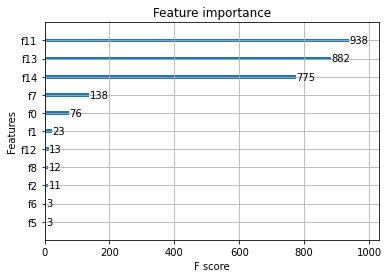

In [137]:
plot_importance(xgb)

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> This score was predictable since I created my segments on RFM Score only and xgboost can easily recreate segments I've done. In a real context this model would be useful to speed up customer segmentation but here itsn't that useful. The positive aspect of it is that we tested it on new customers in the last 2 months with limited number of transactions. This means that we can classify customers with only a few transactions which is quite powerful. </b><br><br>
</div>

***

<h1 id="data_vis" style="font-family:verdana;"> 
    <center>6. Data Visualization with Dash for Jupyter
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#data_vis">¶</a>
    </center>
</h1>

<h2 id="sales" style="font-family:verdana;"> 
         6.1 Total Sales
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#sales">¶</a>

</h2>

In [138]:
custom_aggregation = {}

custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["MonthYear"] = lambda x:x.iloc[0]

custom_aggregation["TotalPrice"] = 'sum'

In [139]:
sales_invoices_montly = df_cleaned.groupby('MonthYear').agg(custom_aggregation).sort_values(by='InvoiceDate')
sales_invoices_montly.head()

,InvoiceDate,MonthYear,TotalPrice
MonthYear,,,
December 2009,2009-12-01 07:45:00,December 2009,610700.98
January 2010,2010-01-29 10:06:00,January 2010,474055.80
February 2010,2010-02-02 13:39:00,February 2010,456027.25
March 2010,2010-03-10 08:31:00,March 2010,600399.79
April 2010,2010-04-20 16:46:00,April 2010,555330.59


In [140]:
data = [go.Scatter(x=sales_invoices_montly.index, 
                   y=sales_invoices_montly['TotalPrice'])]

layout = go.Layout(title="Total sales", title_x=0.5)

fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(type='category')

fig.show()

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> This graph clearly shows that seasonality and especially Christmas has a massive impact on sales. In both 2010 and 2011 sells are growing from august to december </b><br><br>
</div>

<h2 id="countries" style="font-family:verdana;"> 
         6.2 Customers through the world map
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#countries">¶</a>

</h2>

In [141]:
year_options = []
for year in df_cleaned['Year'].unique():
    year_options.append({'label':str(year), 'value':year})
year_options.append({'label':'All', 'value':'All'})

In [142]:
customer_country=df_cleaned[['Country','Customer ID']].drop_duplicates()
df_cleaned_grouped = customer_country.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)


filtered_df_2009 = df_cleaned[df_cleaned['Year']==2009]
customer_country_2009=filtered_df_2009[['Country','Customer ID']].drop_duplicates()
filtered_df_2009_grouped = customer_country_2009.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)

filtered_df_2010 = df_cleaned[df_cleaned['Year']==2010]
customer_country_2010=filtered_df_2010[['Country','Customer ID']].drop_duplicates()
filtered_df_2010_grouped = customer_country_2010.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)

filtered_df_2011 = df_cleaned[df_cleaned['Year']==2011]
customer_country_2011=filtered_df_2011[['Country','Customer ID']].drop_duplicates()
filtered_df_2011_grouped = customer_country_2011.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)

In [143]:
data = [go.Choropleth(
                locations = df_cleaned_grouped['Country'],
                locationmode = 'country names',
                z = df_cleaned_grouped['Customer ID'],
                text = df_cleaned_grouped['Country'],
                colorscale = 'Rainbow',
                marker_line_color='darkgray',
                marker_line_width=0.5,
                colorbar_title = 'Customers',
                ),
        go.Choropleth(
                locations = filtered_df_2009_grouped['Country'],
                locationmode = 'country names',
                z = filtered_df_2009_grouped['Customer ID'],
                text = filtered_df_2009_grouped['Country'],
                colorscale = 'Rainbow',
                marker_line_color='darkgray',
                marker_line_width=0.5,
                colorbar_title = 'Customers',
                ),
        go.Choropleth(
                locations = filtered_df_2010_grouped['Country'],
                locationmode = 'country names',
                z = filtered_df_2010_grouped['Customer ID'],
                text = filtered_df_2010_grouped['Country'],
                colorscale = 'Rainbow',
                marker_line_color='darkgray',
                marker_line_width=0.5,
                colorbar_title = 'Customers',
                ),
        go.Choropleth(
                locations = filtered_df_2011_grouped['Country'],
                locationmode = 'country names',
                z = filtered_df_2011_grouped['Customer ID'],
                text = filtered_df_2011_grouped['Country'],
                colorscale = 'Rainbow',
                marker_line_color='darkgray',
                marker_line_width=0.5,
                colorbar_title = 'Customers',
                ),
       ]

In [144]:
layout = go.Layout(
                title_text='Our customers',
                title_x=0.5,
                geo=dict(
                    showframe=False,
                    showcoastlines=False,
                    projection_type='equirectangular'
                ),
                )

In [145]:
fig = go.Figure(data=data, layout=layout)

In [146]:
# Add dropdown 
fig.update_layout( 
    updatemenus=[ 
        dict( 
            active=0, 
            buttons=list([ 
                dict(label="All", 
                     method="update", 
                     args=[{"visible": [True, False, False, False]}, 
                           {"title": "All customers"}]), 
                dict(label="2009", 
                     method="update", 
                     args=[{"visible": [False, True, False, False]}, 
                           {"title": "Customers in 2009", 
                            }]), 
                dict(label="2010", 
                     method="update", 
                     args=[{"visible": [False, False, True, False]}, 
                           {"title": "Customers in 2010", 
                            }]), 
                dict(label="2011", 
                     method="update", 
                     args=[{"visible": [False, False, False, True]}, 
                           {"title": "Customers in 2011", 
                            }]), 
            ]), 
        ) 
    ]) 
  
fig.show() 

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> This online e-commerce platform has expended through the years internationally. It would be interesting to see how they're doing today.  </b><br><br>
</div>

In [147]:
df_cleaned.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)[:6]

Country
United Kingdom    12517792.41
EIRE                510270.88
Netherlands         506347.92
Germany             374277.99
France              289627.30
Australia           148292.90
Name: TotalPrice, dtype: float64

In [148]:
countries = ['EIRE', 'Netherlands', 'Germany', 'France', 'Australia'] 

countries_options = []
data = []
for country in countries:
    year_options.append({'label':str(country), 'value':country})

for country in countries:
    df_segment = df_cleaned[df_cleaned['Country']==country]
    df_segment_grouped = df_segment.groupby('MonthYear').agg(custom_aggregation).sort_values(by='InvoiceDate')
    
    data.append(go.Bar(x=df_segment_grouped.index, 
                   y=df_segment_grouped['TotalPrice']))
    


In [149]:
layout = go.Layout(
                title_text='Our customers',
                title_x=0.5,
                geo=dict(
                    showframe=False,
                    showcoastlines=False,
                    projection_type='equirectangular'
                ),
                )

In [150]:
fig = go.Figure(data=data, layout=layout)

In [151]:
# Add dropdown 
fig.update_layout( 
    updatemenus=[ 
        dict( 
            active=0, 
            buttons=list([ 
                dict(label=countries[0], 
                     method="update", 
                     args=[{"visible": [True, False, False, False, False]}, 
                           {"title": "{} sells".format(countries[0])}]), 
                dict(label=countries[1], 
                     method="update", 
                     args=[{"visible": [False, True, False, False, False]}, 
                           {"title": "{} sells".format(countries[1])}]), 
                dict(label=countries[2], 
                     method="update", 
                     args=[{"visible": [False, False, True, False, False]}, 
                           {"title": "{} sells".format(countries[2])}]), 
                dict(label=countries[3], 
                     method="update", 
                     args=[{"visible": [False, False, False, True, False]}, 
                           {"title": "{} sells".format(countries[3])}]), 
                dict(label=countries[4], 
                     method="update", 
                     args=[{"visible": [False, False, False, False, True]}, 
                           {"title": "{} sells".format(countries[4])}]), 
                
            ]), 
        ) 
    ]) 
  
fig.show() 

<h2 id="countries" style="font-family:verdana;"> 
         6.3 Customers' Segments
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#countries">¶</a>

</h2>

In [152]:
i = 1
j = 1
data = []
segment_names = ['Best Customers', 'Big Spenders', 'Good Customers', 'Loyal Customers', 'Average Customer', 
                 'Not So Good Customers', 'Almost Lost', 'Lost Customers', 'Bad Customers']
for segment in segment_names:
    df_segment = df_cleaned[df_cleaned['Segment']==segment]
    df_segment_grouped = df_segment.groupby('MonthYear').agg(custom_aggregation).sort_values(by='InvoiceDate')
    
    data.append(go.Scatter(x=df_segment_grouped.index, 
                   y=df_segment_grouped['TotalPrice']))
    
fig = make_subplots(rows=3, cols=3, shared_yaxes=True, vertical_spacing=0.19, subplot_titles=(segment_names[0], segment_names[1], segment_names[2], segment_names[3], segment_names[4], segment_names[5], 
                                  segment_names[6], segment_names[7], segment_names[8]))    
    
k = 0
for i in range(1,4):
    for j in range(1,4):
        fig.add_trace(data[k], row=i, col=j)
        k+=1


fig.update_layout(height=1000, width=1000, title_text="Sales Through segments", title_x=0.5
                  )
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10,color='#ff0000')
fig.show()

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> It seems that our segment categories can be improved. As I said earlier this should be done in partnership with the marketing team. For example, the segment "Not So Good Customers" seems to have better sells than the average customers. The problem seems to be in december 2010 because there was a massive decrease in sells this month. We also have a good representation of the segment "Best customers" since they have the biggest sales. Lastly, we can see graphically why we labeled these categories "almost lost" and "lost customers"  </b><br><br>
</div>

<h2 id="prod_sells" style="font-family:verdana;"> 
         6.4 Most sold products
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#prod_sells">¶</a>

</h2>

In [153]:
most_sold_prod = df_cleaned.groupby(['Description'])['Quantity'].sum().sort_values(ascending=False)[:10]

data = [go.Bar(x=most_sold_prod.index, 
               y=most_sold_prod.values)]

layout = go.Layout(title="TOP 10 most sold products", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [154]:
i = 1
j = 1
data = []
prod_names= []
for product in most_sold_prod.index[0:9]:
    df_product = df_cleaned[df_cleaned['Description']==product]
    df_product_grouped = df_product.groupby('MonthYear').agg(custom_aggregation).sort_values(by='InvoiceDate')
    
    data.append(go.Scatter(x=df_product_grouped.index, 
                   y=df_product_grouped['TotalPrice']))
    prod_names.append(product)
    
fig = make_subplots(rows=3, cols=3, vertical_spacing=0.19, subplot_titles=(prod_names[0], prod_names[1], prod_names[2], prod_names[3], prod_names[4], prod_names[5], 
                                  prod_names[6], prod_names[7], prod_names[8]))    
    
k = 0
for i in range(1,4):
    for j in range(1,4):
        fig.add_trace(data[k], row=i, col=j)
        k+=1


fig.update_layout(height=1000, width=1000, title_text="Best products monthly sales", title_x=0.5
                  )
for i in fig['layout']['annotations']:
    i['font'] = dict(size=10,color='#ff0000')
fig.show()

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> This graph would be much more interesting if I could do it in Dash since we could select whatever product we're interested into and see its sells through the year. I'll incorporate it in my future dashboard. The main information we can drive from this graph is that we shouldn't keep the following products in the database "Paper craft" and "Storage Jar" since there are so much canceled ordrers. </b><br><br>
</div>

In [155]:
prod_categories = df_cleaned.groupby('Labels')['TotalPrice'].sum()

In [156]:
data = [go.Pie(labels=prod_categories.index, 
                   values=prod_categories.values)]

layout = go.Layout(title="Total sales through product categories", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()

<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> The work done on product categories doesn't seem to be very representative of the real sells, I'll rework this part in a new version. </b><br><br>
</div>

<h2 id="time_graphs" style="font-family:verdana;"> 
         6.5 Time Features
        <a class="anchor-link" href="https://www.kaggle.com/miljan/product-tagging-for-e-commerce-work-in-progress/#time_graphs">¶</a>

</h2>

In [157]:
hourly_sales = df_cleaned.groupby('Hour')['TotalPrice'].sum().sort_index(ascending=True)
hourly_sales

Hour
6           4.25
7       69672.35
8      476018.04
9     1148761.36
10    1982572.99
11    1897771.55
12    2406094.87
13    2111271.66
14    1815394.96
15    1573177.09
16     874414.68
17     410044.66
18     151741.33
19     112667.69
20      28206.06
Name: TotalPrice, dtype: float64

In [158]:
data = [go.Bar(x=hourly_sales.index, 
               y=hourly_sales.values)]

layout = go.Layout(title="Hourly sales", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()

In [159]:
weekday_sales = df_cleaned.groupby('Weekday')['TotalPrice'].sum().sort_index(ascending=True)

data = [go.Bar(x=weekday_sales.index, 
               y=weekday_sales.values)]

layout = go.Layout(title="Weekday sales", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()


<br><br>
<div class="alert alert-block alert-info" style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <b> I really can't believe that there's a day in the week where sells are dropping that drastically. It must be an error. </b><br><br>
</div>

In [160]:
day_sales = df_cleaned.groupby('Day')['TotalPrice'].sum().sort_index(ascending=True)

data = [go.Bar(x=day_sales.index, 
               y=day_sales.values)]

layout = go.Layout(title="Day of the month sales", title_x=0.5)

fig = go.Figure(data=data, layout=layout)

fig.show()


<center style="font-family:cursive; font-size:18px; color:#159364;">This is a work in progress, feel free to suggest any graphics that you would like to see. <br>I'm going to add more visualizations and then create a dashboard that I'll share with you.<br> Thank you for taking your time to read my notebook 🙏 </center>

***